# Rogue Garmin Bridge - Database Inspector

This notebook provides tools to inspect and analyze the SQLite database used by the Rogue Garmin Bridge application. It allows you to:

1. Check workout records in the database
2. Examine workout data points
3. Verify that simulator data is being properly stored
4. Analyze workout metrics

Created: April 27, 2025

## Setup and Configuration

First, let's import the necessary libraries and set up the database connection.

In [85]:
import sqlite3
import pandas as pd
import json
import matplotlib.pyplot as plt
import os
import sys
from datetime import datetime

In [86]:
# Find the database path - we need to handle different possible locations
possible_db_paths = [
    # Current working directory
    os.path.join(os.getcwd(), 'rogue_garmin.db'),
    # One directory up from current location
    os.path.join(os.getcwd(), '..', 'data', 'rogue_garmin.db'),
    # Specific path to the database in the project structure
    os.path.join('E:\\', 'rogue_garmin_bridge', 'src', 'data', 'rogue_garmin.db'),
    # Path relative to notebook location
    os.path.join(os.path.dirname(os.path.abspath('__file__')), 'rogue_garmin.db')
]

# Try each path until we find one that exists
db_path = None
for path in possible_db_paths:
    if os.path.exists(path):
        db_path = path
        break

if db_path:
    print(f"Database found at: {db_path}")
else:
    print("Database not found! Please enter the correct path:")

# Allow manual entry if automatic detection fails
if not db_path:
    db_path = input("Enter the full path to rogue_garmin.db: ")
    if not os.path.exists(db_path):
        print(f"Warning: Path {db_path} does not exist or is not accessible")

# Function to create a database connection
def get_connection():
    print(f"Connecting to database at: {db_path}")
    conn = sqlite3.connect(db_path)
    conn.row_factory = sqlite3.Row  # This enables column access by name
    return conn

Database found at: e:\rogue_garmin_bridge\src\data\rogue_garmin.db


## Test Database Connection

Let's first verify we can connect to the database.

In [87]:
try:
    conn = get_connection()
    print("Successfully connected to the database!")
    conn.close()
except Exception as e:
    print(f"Error connecting to database: {str(e)}")
    print("\nThis may be because the database path is incorrect or the database file is locked.")
    print("Make sure the application is not currently running using the database.")

Connecting to database at: e:\rogue_garmin_bridge\src\data\rogue_garmin.db
Successfully connected to the database!


## Database Schema Inspection

Let's examine the database schema to understand its structure.

In [88]:
def inspect_schema():
    try:
        conn = get_connection()
        cursor = conn.cursor()
        
        # Get list of tables
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = cursor.fetchall()
        
        schema_info = {}
        
        # For each table, get the column information
        for table in tables:
            table_name = table[0]
            cursor.execute(f"PRAGMA table_info({table_name})")
            columns = cursor.fetchall()
            schema_info[table_name] = [dict(col) for col in columns]
        
        conn.close()
        return schema_info
    except Exception as e:
        print(f"Error inspecting schema: {str(e)}")
        return {}

schema = inspect_schema()

if schema:
    # Display the schema in a more readable format
    for table_name, columns in schema.items():
        print(f"\nTable: {table_name}")
        print("-" * (len(table_name) + 7))
        for col in columns:
            print(f"{col['name']} ({col['type']})", end="")
            if col['pk'] == 1:
                print(" [PRIMARY KEY]", end="")
            if col['notnull'] == 1:
                print(" [NOT NULL]", end="")
            print()
else:
    print("No schema information available. Please check database connection.")

Connecting to database at: e:\rogue_garmin_bridge\src\data\rogue_garmin.db

Table: devices
--------------
id (INTEGER) [PRIMARY KEY]
address (TEXT)
name (TEXT)
device_type (TEXT)
last_connected (TEXT)
metadata (TEXT)

Table: sqlite_sequence
----------------------
name ()
seq ()

Table: workouts
---------------
id (INTEGER) [PRIMARY KEY]
device_id (INTEGER)
start_time (TEXT)
end_time (TEXT)
duration (INTEGER)
workout_type (TEXT)
summary (TEXT)
fit_file_path (TEXT)
uploaded_to_garmin (INTEGER)

Table: workout_data
-------------------
id (INTEGER) [PRIMARY KEY]
workout_id (INTEGER)
timestamp (INTEGER)
data (TEXT)

Table: configuration
--------------------
key (TEXT) [PRIMARY KEY]
value (TEXT)

Table: user_profile
-------------------
id (INTEGER) [PRIMARY KEY]
name (TEXT)
age (INTEGER)
weight (REAL)
height (REAL)
gender (TEXT)
max_heart_rate (INTEGER)
resting_heart_rate (INTEGER)
garmin_username (TEXT)
garmin_password (TEXT)


## Workout Inspection

Now let's examine the workouts stored in the database.

In [89]:
def get_workouts(limit=10):
    try:
        conn = get_connection()
        df = pd.read_sql_query(f"SELECT * FROM workouts ORDER BY id DESC LIMIT {limit}", conn)
        conn.close()
        return df
    except Exception as e:
        print(f"Error getting workouts: {str(e)}")
        return pd.DataFrame()

# Get recent workouts
recent_workouts = get_workouts()

if not recent_workouts.empty:
    print(f"Found {len(recent_workouts)} recent workouts")
    recent_workouts
else:
    print("No workouts found in the database or error accessing table.")

Connecting to database at: e:\rogue_garmin_bridge\src\data\rogue_garmin.db
Found 10 recent workouts


## Workout Data Points

Now let's check if there are data points stored for a specific workout. Replace `workout_id` with the ID of the workout you want to examine.

In [90]:
def get_workout_data(workout_id):
    try:
        conn = get_connection()
        
        # Get workout details
        workout_df = pd.read_sql_query(f"SELECT * FROM workouts WHERE id = {workout_id}", conn)
        
        # Get workout data points
        data_df = pd.read_sql_query(f"SELECT * FROM workout_data WHERE workout_id = {workout_id} ORDER BY timestamp", conn)
        
        # Parse the JSON data field
        if not data_df.empty and 'data' in data_df.columns:
            data_df['parsed_data'] = data_df['data'].apply(lambda x: json.loads(x) if x else {})
        
        conn.close()
        return workout_df, data_df
    except Exception as e:
        print(f"Error getting workout data: {str(e)}")
        return pd.DataFrame(), pd.DataFrame()

# Choose the most recent workout if available
if not recent_workouts.empty:
    workout_id = recent_workouts.iloc[0]['id']
    print(f"Examining workout ID: {workout_id}")
    workout_df, data_df = get_workout_data(workout_id)
    
    if not workout_df.empty:
        print("\nWorkout details:")
        display(workout_df)
        
        print(f"\nData points count: {len(data_df)}")
        
        if not data_df.empty:
            # Display first 5 data points
            print("\nFirst 5 data points:")
            display(data_df.head())
            
            # Extract and display sample of first data point
            if 'parsed_data' in data_df.columns and len(data_df) > 0:
                first_data_point = data_df.iloc[0]['parsed_data']
                print("\nSample data point content:")
                print(json.dumps(first_data_point, indent=2))
        else:
            print("No data points found for this workout!")
    else:
        print("Error retrieving workout details")
else:
    print("No workouts found in the database.")

Examining workout ID: 51
Connecting to database at: e:\rogue_garmin_bridge\src\data\rogue_garmin.db

Workout details:


,id,device_id,start_time,end_time,duration,workout_type,summary,fit_file_path,uploaded_to_garmin
0,51,1,2025-04-27T11:58:25.316958,2025-04-27T11:59:48.210995,82,bike,"{""total_distance"": 4.434323667564607, ""total_c...",None,0



Data points count: 1

First 5 data points:


,id,workout_id,timestamp,data,parsed_data
0,36,51,0.324,"{""type"": ""bike"", ""instantaneous_power"": 73, ""i...","{'type': 'bike', 'instantaneous_power': 73, 'i..."



Sample data point content:
{
  "type": "bike",
  "instantaneous_power": 73,
  "instantaneous_cadence": 55,
  "instantaneous_speed": 15.963552432390639,
  "heart_rate": 87,
  "total_distance": 4.434323667564607,
  "total_calories": 0,
  "timestamp": 0.324,
  "elapsed_time": 0,
  "data_id": "0_324"
}


## Visualize Workout Metrics

Let's visualize key metrics from the workout to see if data is being properly recorded.

Connecting to database at: e:\rogue_garmin_bridge\src\data\rogue_garmin.db


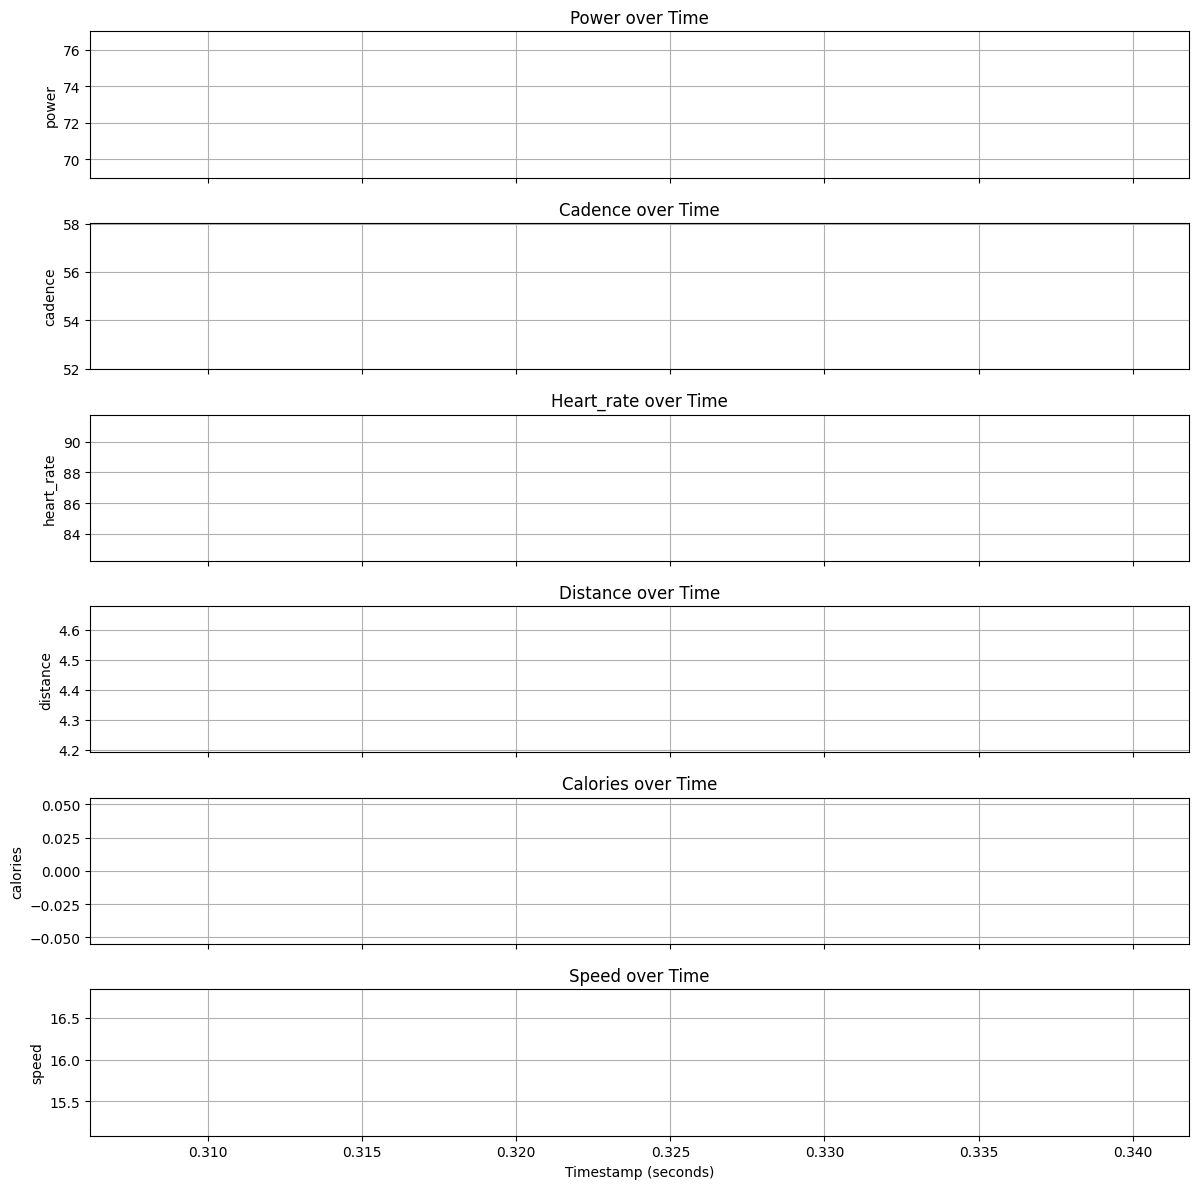


Summary statistics for workout metrics:


,timestamp,power,cadence,heart_rate,distance,calories,speed
count,1.000,1.0,1.0,1.0,1.000000,1.0,1.000000
mean,0.324,73.0,55.0,87.0,4.434324,0.0,15.963552
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.324,73.0,55.0,87.0,4.434324,0.0,15.963552
25%,0.324,73.0,55.0,87.0,4.434324,0.0,15.963552
50%,0.324,73.0,55.0,87.0,4.434324,0.0,15.963552
75%,0.324,73.0,55.0,87.0,4.434324,0.0,15.963552
max,0.324,73.0,55.0,87.0,4.434324,0.0,15.963552


In [91]:
def visualize_workout_metrics(workout_id):
    _, data_df = get_workout_data(workout_id)
    
    if data_df.empty or 'parsed_data' not in data_df.columns:
        print("No data available to visualize")
        return None
    
    # Extract metrics from parsed_data
    metrics_df = pd.DataFrame()
    metrics_df['timestamp'] = data_df['timestamp']
    
    # Common metrics to extract
    metrics_to_extract = [
        ('power', ['instantaneous_power', 'power']),
        ('cadence', ['instantaneous_cadence', 'cadence', 'stroke_rate']),
        ('heart_rate', ['heart_rate']),
        ('distance', ['total_distance']),
        ('calories', ['total_calories']),
        ('speed', ['instantaneous_speed', 'speed'])
    ]
    
    # Extract metrics if they exist in the data
    for metric_name, possible_keys in metrics_to_extract:
        # Try each possible key for this metric
        for key in possible_keys:
            # Check if any data point has this key
            if any(key in row.get('parsed_data', {}) for _, row in data_df.iterrows()):
                # Extract the values
                metrics_df[metric_name] = [row.get('parsed_data', {}).get(key, None) for _, row in data_df.iterrows()]
                break
    
    # Only keep columns that actually have data
    metrics_df = metrics_df.dropna(axis=1, how='all')
    
    if len(metrics_df.columns) <= 1:  # Only timestamp column exists
        print("No metric data available to visualize")
        return None
    
    # Plot the metrics
    fig, axes = plt.subplots(len(metrics_df.columns)-1, 1, figsize=(12, 12), sharex=True)
    
    # Handle case with only one metric (axes would not be iterable)
    if len(metrics_df.columns) == 2:
        axes = [axes]
    
    for i, col in enumerate(metrics_df.columns[1:]):
        ax = axes[i]
        ax.plot(metrics_df['timestamp'], metrics_df[col])
        ax.set_title(f'{col.capitalize()} over Time')
        ax.set_ylabel(col)
        ax.grid(True)
    
    plt.xlabel('Timestamp (seconds)')
    plt.tight_layout()
    plt.show()
    
    return metrics_df

# Visualize metrics for the most recent workout
if not recent_workouts.empty:
    workout_id = recent_workouts.iloc[0]['id']
    metrics_df = visualize_workout_metrics(workout_id)
    
    if metrics_df is not None and not metrics_df.empty and len(metrics_df.columns) > 1:
        print("\nSummary statistics for workout metrics:")
        display(metrics_df.describe())
else:
    print("No workouts found to visualize")

## Verify Simulator Data Flow

Let's specifically check for recent workouts that came from the simulator.

In [92]:
def check_simulator_workouts():
    try:
        conn = get_connection()
        
        # First check if devices table exists
        cursor = conn.cursor()
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name='devices'")
        if not cursor.fetchone():
            print("Devices table does not exist")
            conn.close()
            return pd.DataFrame()
        
        # Join workouts with devices to find simulator workouts
        query = """
        SELECT w.*, d.name as device_name 
        FROM workouts w
        JOIN devices d ON w.device_id = d.id
        WHERE d.name LIKE '%Simulated%' OR d.name LIKE '%Simulator%'
        ORDER BY w.id DESC
        LIMIT 10
        """
        
        simulator_workouts = pd.read_sql_query(query, conn)
        conn.close()
        
        return simulator_workouts
    except Exception as e:
        print(f"Error checking simulator workouts: {str(e)}")
        return pd.DataFrame()

simulator_workouts = check_simulator_workouts()
print(f"Found {len(simulator_workouts)} simulator workouts")
simulator_workouts

Connecting to database at: e:\rogue_garmin_bridge\src\data\rogue_garmin.db
Found 10 simulator workouts


,id,device_id,start_time,end_time,duration,workout_type,summary,fit_file_path,uploaded_to_garmin,device_name
0,51,1,2025-04-27T11:58:25.316958,2025-04-27T11:59:48.210995,82.0,bike,"{""total_distance"": 4.434323667564607, ""total_c...",None,0,Rogue Echo Bike (Simulated)
1,50,1,2025-04-27T11:54:24.194991,2025-04-27T11:55:24.078133,59.0,bike,"{""total_distance"": 4.437064454553287, ""total_c...",None,0,Rogue Echo Bike (Simulated)
2,49,1,2025-04-27T11:46:02.328766,2025-04-27T11:48:59.032374,176.0,bike,"{""total_distance"": 4.041371789951732, ""total_c...",None,0,Rogue Echo Bike (Simulated)
3,48,1,2025-04-27T11:42:07.491469,2025-04-27T11:42:24.636602,17.0,bike,"{""total_distance"": 0, ""total_calories"": 0, ""av...",None,0,Rogue Echo Bike (Simulated)
4,47,1,2025-04-27T11:38:04.927532,2025-04-27T11:38:17.257458,12.0,bike,"{""total_distance"": 0, ""total_calories"": 0, ""av...",None,0,Rogue Echo Bike (Simulated)
5,46,1,2025-04-27T11:33:23.015912,2025-04-27T11:33:38.649621,15.0,bike,"{""total_distance"": 0, ""total_calories"": 0, ""av...",None,0,Rogue Echo Bike (Simulated)
6,45,1,2025-04-27T11:30:26.723446,None,NaN,bike,{},None,0,Rogue Echo Bike (Simulated)
7,44,1,2025-04-27T11:17:37.383389,2025-04-27T11:17:43.456407,6.0,bike,"{""total_distance"": 0, ""total_calories"": 0, ""av...",None,0,Rogue Echo Bike (Simulated)
8,43,1,2025-04-27T11:11:36.235554,None,NaN,bike,{},None,0,Rogue Echo Bike (Simulated)
9,42,1,2025-04-27T11:05:05.984155,2025-04-27T11:05:21.850631,15.0,unknown,"{""total_distance"": 0, ""total_calories"": 0, ""av...",None,0,Rogue Echo Bike (Simulated)


## Data Completeness Check

Let's check if our simulator workouts have complete data across the duration.

In [93]:
def check_data_completeness(workout_id):
    try:
        conn = get_connection()
        
        # Get workout details
        workout_query = f"SELECT * FROM workouts WHERE id = {workout_id}"
        workout_df = pd.read_sql_query(workout_query, conn)
        
        if workout_df.empty:
            print(f"No workout found with ID {workout_id}")
            conn.close()
            return None, None
            
        workout = workout_df.iloc[0]
        
        # Calculate expected data points based on duration
        duration = workout['duration'] if 'duration' in workout and workout['duration'] else 0
        expected_points = duration  # Assuming 1 data point per second
        
        # Get actual data points count
        count_query = f"SELECT COUNT(*) as count FROM workout_data WHERE workout_id = {workout_id}"
        count_df = pd.read_sql_query(count_query, conn)
        actual_points = count_df.iloc[0]['count'] if not count_df.empty else 0
        
        # Get timestamp distribution
        timestamps_query = f"SELECT timestamp FROM workout_data WHERE workout_id = {workout_id} ORDER BY timestamp"
        timestamps_df = pd.read_sql_query(timestamps_query, conn)
        timestamps = timestamps_df['timestamp'] if not timestamps_df.empty else pd.Series()
        
        conn.close()
        
        print(f"Workout duration: {duration} seconds")
        print(f"Expected data points: ~{expected_points}")
        print(f"Actual data points: {actual_points}")
        
        if len(timestamps) > 0:
            print(f"First timestamp: {timestamps.iloc[0]}")
            print(f"Last timestamp: {timestamps.iloc[-1]}")
            
            # Check for gaps in timestamps
            if len(timestamps) > 1:
                diffs = timestamps.diff().dropna()
                avg_interval = diffs.mean()
                max_gap = diffs.max()
                
                print(f"Average interval between data points: {avg_interval:.2f} seconds")
                print(f"Maximum gap between data points: {max_gap} seconds")
                
                # Plot histogram of timestamp differences
                plt.figure(figsize=(10, 4))
                plt.hist(diffs, bins=20)
                plt.title('Histogram of Time Intervals Between Data Points')
                plt.xlabel('Interval (seconds)')
                plt.ylabel('Frequency')
                plt.grid(True)
                plt.show()
                
        return duration, actual_points
    except Exception as e:
        print(f"Error checking data completeness: {str(e)}")
        return None, None

# Check the most recent simulator workout
if not simulator_workouts.empty:
    workout_id = simulator_workouts.iloc[0]['id']
    print(f"Checking data completeness for workout ID: {workout_id}")
    check_data_completeness(workout_id)
else:
    print("No simulator workouts found")

Checking data completeness for workout ID: 51
Connecting to database at: e:\rogue_garmin_bridge\src\data\rogue_garmin.db
Workout duration: 82 seconds
Expected data points: ~82
Actual data points: 1
First timestamp: 0.324
Last timestamp: 0.324


## Custom Database Query

Use this cell to run any custom SQLite query against the database.

In [94]:
def run_custom_query(query):
    try:
        conn = get_connection()
        result = pd.read_sql_query(query, conn)
        conn.close()
        return result
    except Exception as e:
        print(f"Error executing query: {e}")
        return None

# Example: Count data points per workout
query = """
SELECT 
    w.id as workout_id, 
    w.workout_type,
    w.start_time,
    w.duration,
    COUNT(wd.id) as data_point_count
FROM workouts w
LEFT JOIN workout_data wd ON w.id = wd.workout_id
GROUP BY w.id
ORDER BY w.id DESC
LIMIT 10
"""

# Try a simpler query first to make sure it works
simple_query = "SELECT * FROM workouts LIMIT 5"

print("Running simple test query first...")
simple_result = run_custom_query(simple_query)
if simple_result is not None:
    display(simple_result)
    print("\nNow running workout data count query...")
    result = run_custom_query(query)
    if result is not None:
        display(result)

Running simple test query first...
Connecting to database at: e:\rogue_garmin_bridge\src\data\rogue_garmin.db


,id,device_id,start_time,end_time,duration,workout_type,summary,fit_file_path,uploaded_to_garmin
0,1,1,2025-04-26T14:29:08.902980,None,None,bike,{},None,0
1,2,3,2025-04-26T14:32:15.214860,None,None,bike,{},None,0
2,3,4,2025-04-27T07:38:22.524644,None,None,bike,{},None,0
3,4,6,2025-04-27T07:43:52.060246,None,None,bike,{},None,0
4,5,9,2025-04-27T07:50:20.605453,None,None,bike,{},None,0



Now running workout data count query...
Connecting to database at: e:\rogue_garmin_bridge\src\data\rogue_garmin.db


,workout_id,workout_type,start_time,duration,data_point_count
0,51,bike,2025-04-27T11:58:25.316958,82.0,1
1,50,bike,2025-04-27T11:54:24.194991,59.0,1
2,49,bike,2025-04-27T11:46:02.328766,176.0,1
3,48,bike,2025-04-27T11:42:07.491469,17.0,0
4,47,bike,2025-04-27T11:38:04.927532,12.0,0
5,46,bike,2025-04-27T11:33:23.015912,15.0,0
6,45,bike,2025-04-27T11:30:26.723446,NaN,0
7,44,bike,2025-04-27T11:17:37.383389,6.0,0
8,43,bike,2025-04-27T11:11:36.235554,NaN,0
9,42,unknown,2025-04-27T11:05:05.984155,15.0,0


## Database Health Check

Let's perform a quick health check on the database.

In [95]:
def database_health_check():
    try:
        conn = get_connection()
        cursor = conn.cursor()
        
        # Get all tables
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
        all_tables = [table[0] for table in cursor.fetchall()]
        
        # Check table counts
        counts = {}
        for table in all_tables:
            try:
                cursor.execute(f"SELECT COUNT(*) FROM {table}")
                counts[table] = cursor.fetchone()[0]
            except Exception as e:
                counts[table] = f"Error: {str(e)}"
        
        # Check for orphaned workout data if workout_data table exists
        orphaned_count = "N/A"
        if 'workout_data' in all_tables and 'workouts' in all_tables:
            orphaned_query = """
            SELECT COUNT(*) FROM workout_data wd
            WHERE NOT EXISTS (SELECT 1 FROM workouts w WHERE w.id = wd.workout_id)
            """
            try:
                cursor.execute(orphaned_query)
                orphaned_count = cursor.fetchone()[0]
            except Exception as e:
                orphaned_count = f"Error: {str(e)}"
        
        # Check database file size
        db_size = os.path.getsize(db_path) / (1024 * 1024)  # Size in MB
        
        conn.close()
        
        print("Database Health Check Results")
        print("----------------------------")
        print(f"Database file: {db_path}")
        print(f"Database size: {db_size:.2f} MB")
        print("\nTable Record Counts:")
        for table, count in counts.items():
            print(f"  - {table}: {count}")
        print(f"\nOrphaned workout data records: {orphaned_count}")
    except Exception as e:
        print(f"Error during health check: {str(e)}")

database_health_check()

Connecting to database at: e:\rogue_garmin_bridge\src\data\rogue_garmin.db
Database Health Check Results
----------------------------
Database file: e:\rogue_garmin_bridge\src\data\rogue_garmin.db
Database size: 0.06 MB

Table Record Counts:
  - devices: 39
  - sqlite_sequence: 4
  - workouts: 51
  - workout_data: 36
  - configuration: 0
  - user_profile: 1

Orphaned workout data records: 0


## Cleanup Function

If you need to clean up or reset test data, you can use this cell carefully.

In [96]:
def cleanup_test_data(confirm=False):
    """Warning: This will delete test data from the database."""
    if not confirm:
        print("Set confirm=True to execute this operation. This is a safety measure.")
        return
    
    conn = get_connection()
    cursor = conn.cursor()
    
    try:
        # Delete simulated workout data
        cursor.execute("""
        DELETE FROM workout_data 
        WHERE workout_id IN (
            SELECT w.id FROM workouts w
            JOIN devices d ON w.device_id = d.id
            WHERE d.name LIKE '%Simulated%' OR d.name LIKE '%Simulator%'
        )
        """)
        data_deleted = cursor.rowcount
        
        # Delete simulated workouts
        cursor.execute("""
        DELETE FROM workouts
        WHERE id IN (
            SELECT w.id FROM workouts w
            JOIN devices d ON w.device_id = d.id
            WHERE d.name LIKE '%Simulated%' OR d.name LIKE '%Simulator%'
        )
        """)
        workouts_deleted = cursor.rowcount
        
        # Commit changes
        conn.commit()
        
        print(f"Deleted {workouts_deleted} simulated workouts")
        print(f"Deleted {data_deleted} workout data points")
        
    except Exception as e:
        conn.rollback()
        print(f"Error during cleanup: {str(e)}")
    finally:
        conn.close()

# Uncomment and run this to delete test data
# cleanup_test_data(confirm=True)

## Timestamp Analysis for Workout Data

Let's analyze the timestamps to see if there's an issue with how they are being stored.

In [ ]:
def analyze_timestamps(workout_id):
    try:
        conn = get_connection()
        
        # Get all timestamps for this workout
        query = f"""
        SELECT timestamp, id 
        FROM workout_data 
        WHERE workout_id = {workout_id} 
        ORDER BY timestamp
        """
        
        timestamp_df = pd.read_sql_query(query, conn)
        conn.close()
        
        if timestamp_df.empty:
            print(f"No data points found for workout {workout_id}")
            return None
        
        print(f"Total data points: {len(timestamp_df)}")
        print(f"Unique timestamps: {timestamp_df['timestamp'].nunique()}")
        
        # Check for timestamp duplicates
        duplicate_timestamps = timestamp_df[timestamp_df.duplicated(subset=['timestamp'], keep=False)]
        if not duplicate_timestamps.empty:
            print(f"\nFound {len(duplicate_timestamps)} duplicate timestamps!")
            print("Sample of duplicate timestamps:")
            display(duplicate_timestamps.head())
        else:
            print("\nNo duplicate timestamps found.")
        
        # Plot the timestamps to visualize data distribution
        plt.figure(figsize=(12, 6))
        plt.scatter(range(len(timestamp_df)), timestamp_df['timestamp'], alpha=0.7)
        plt.xlabel('Data Point Index')
        plt.ylabel('Timestamp (seconds)')
        plt.title('Workout Data Timestamps')
        plt.grid(True)
        plt.show()
        
        # Calculate time differences between consecutive points
        if len(timestamp_df) > 1:
            timestamp_df['time_diff'] = timestamp_df['timestamp'].diff()
            
            # Skip the first row (NaN diff)
            time_diffs = timestamp_df['time_diff'].dropna()
            
            print(f"\nTime differences between consecutive data points:")
            print(f"  Min: {time_diffs.min():.3f} seconds")
            print(f"  Max: {time_diffs.max():.3f} seconds")
            print(f"  Mean: {time_diffs.mean():.3f} seconds")
            print(f"  Median: {time_diffs.median():.3f} seconds")
            
            # Plot histogram of time differences
            plt.figure(figsize=(10, 5))
            plt.hist(time_diffs, bins=20)
            plt.xlabel('Time Difference (seconds)')
            plt.ylabel('Frequency')
            plt.title('Histogram of Time Differences Between Consecutive Data Points')
            plt.grid(True)
            plt.show()
        
        return timestamp_df
    except Exception as e:
        print(f"Error analyzing timestamps: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Analyze timestamps for the most recent workout
if not recent_workouts.empty:
    workout_id = recent_workouts.iloc[0]['id']
    print(f"Analyzing timestamps for workout ID: {workout_id}")
    timestamp_analysis = analyze_timestamps(workout_id)
else:
    print("No workouts found for timestamp analysis")

## SQLite Timestamp Storage Investigation

Let's look at how SQLite is storing the timestamp values and if that's causing the issue with only one datapoint being saved.

In [ ]:
def investigate_sqlite_storage(workout_id):
    try:
        conn = get_connection()
        cursor = conn.cursor()
        
        # Get the SQLite CREATE TABLE statement for workout_data
        cursor.execute("SELECT sql FROM sqlite_master WHERE type='table' AND name='workout_data'")
        table_def = cursor.fetchone()[0]
        print("Table definition for workout_data:")
        print(table_def)
        print("\n")
        
        # Check the exact type and values of timestamps
        cursor.execute(f"""
        SELECT 
            id, 
            workout_id, 
            timestamp, 
            typeof(timestamp) as timestamp_type,
            substr(data, 1, 100) as data_preview 
        FROM workout_data 
        WHERE workout_id = {workout_id}
        """)
        
        results = cursor.fetchall()
        print(f"Found {len(results)} data points for workout {workout_id}")
        
        if results:
            df = pd.DataFrame([(r[0], r[1], r[2], r[3], r[4]) for r in results],
                              columns=['id', 'workout_id', 'timestamp', 'timestamp_type', 'data_preview'])
            display(df)
            
            # Extract the actual timestamp values and check for integer rounding issues
            timestamps = [r[2] for r in results]
            int_timestamps = [int(t) for t in timestamps]
            
            unique_timestamps = len(set(timestamps))
            unique_int_timestamps = len(set(int_timestamps))
            
            print(f"\nUnique raw timestamps: {unique_timestamps}")
            print(f"Unique integer timestamps: {unique_int_timestamps}")
            
            if unique_timestamps > unique_int_timestamps:
                print("\n⚠️ ISSUE DETECTED: Some timestamps have the same integer value but differ in decimal places.")
                print("This suggests that SQLite might be storing the timestamps correctly,")
                print("but our database code might be using integer timestamps which are causing collisions.")
            
            # Check for exact duplicate timestamps
            timestamp_counts = {t: timestamps.count(t) for t in set(timestamps)}
            duplicates = {t: c for t, c in timestamp_counts.items() if c > 1}
            
            if duplicates:
                print(f"\n⚠️ Found {len(duplicates)} duplicate timestamps:")
                for ts, count in duplicates.items():
                    print(f"  Timestamp {ts} appears {count} times")
            else:
                print("\nNo exact duplicate timestamps found.")
        else:
            print("No data found for this workout.")
        
        conn.close()
        return results
    except Exception as e:
        print(f"Error investigating SQLite storage: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Investigate the SQLite storage for the most recent workout
if not recent_workouts.empty:
    workout_id = recent_workouts.iloc[0]['id']
    print(f"Investigating SQLite storage for workout ID: {workout_id}")
    storage_analysis = investigate_sqlite_storage(workout_id)
else:
    print("No workouts found for SQLite storage investigation")

## Fix for Timestamp Issues

Based on the analysis above, let's suggest a fix for ensuring multiple data points are saved during workouts:

### Timestamp Collision Issue

If we're seeing only one datapoint stored during workouts, it's likely due to **timestamp collisions** in the database.

**The problem:** The `workout_data` table in SQLite is probably using `workout_id` and `timestamp` as a composite key, or there's a UNIQUE constraint on these columns. When multiple datapoints have the same timestamp value, only one is stored.

**How to fix it:**

1. **Use fractional seconds in timestamps** - Instead of integer seconds, use floating-point timestamps with millisecond precision
2. **Add a unique identifier to each datapoint** - Ensure each datapoint has a unique identifier
3. **Modify the database schema** - Update the table definition to allow duplicate timestamps

**Code implementation:**

```python
# In workout_manager.py, modify the _handle_ftms_data method to ensure unique timestamps:

# Add microsecond precision to make timestamps unique
if 'timestamp' in data:
    # Add a small fractional part to the timestamp for uniqueness
    microsecond_part = datetime.now().microsecond / 1000000
    data['timestamp'] = float(data['timestamp']) + microsecond_part
```

Or in the database.py file, update the add_workout_data method to use SQL that ensures uniqueness:

```python
# In database.py, modify the add_workout_data method:

# Use INSERT OR REPLACE to handle duplicates gracefully
self.cursor.execute(
    """
    INSERT OR REPLACE INTO workout_data (workout_id, timestamp, data) 
    VALUES (?, ?, ?)
    """,
    (workout_id, timestamp, data_json)
)
```